# Sentinel-2 cropland mapping

Following the paper by [Belgiu & Csillik (2018)] (see also [Hao et al. 2018](https://peerj.com/articles/5431/?utm_source=TrendMD&utm_campaign=PeerJ_TrendMD_0&utm_medium=TrendMD))(https://www.sciencedirect.com/science/article/pii/S0034425717304686) we can train a CNN for the segmentation of the croplands. As an input we can use [Sentinel-2 MSI](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) multispectral data, and as an output crop types data classified by experts from the European Land Use and Coverage Area Frame Survey ([LUCAS](https://ec.europa.eu/eurostat/statistics-explained/index.php/LUCAS_-_Land_use_and_land_cover_survey)) and  CropScape – Cropland Data Layer ([CDL](https://nassgeodata.gmu.edu/CropScape/)), respectively.

Datasets in Google Earth Engine:

- [Sentinel-2 MSI: MultiSpectral Instrument, Level-1C](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2)
- [USDA NASS Cropland Data Layers](https://developers.google.com/earth-engine/datasets/catalog/USDA_NASS_CDL)
- [Canada AAFC Annual Crop Inventory](https://developers.google.com/earth-engine/datasets/catalog/AAFC_ACI) 
***

In [950]:
from urllib.request import urlopen
import zipfile
import rasterio
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import display, Image
import os, urllib
import numpy as np
import pandas as pd
import math
import ee

Initialize the Earth Engine client.

In [2]:
ee.Initialize()

## Download data from Earth Engine

In [459]:
def maskS2clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = int(2**10)
    cirrusBitMask = int(2**11)

    # Both flags set to zero indicates clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(\
           qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000)

In [460]:
def display_image(image, region, mn, mx, bandNames=False, gamma=False, title=False):
    """
    Displays images in notebook
    """
    
    if title:
        print('\n',title)
 
    if not gamma:
        gamma = 1
        
    if bandNames:
        image = image.select(bandNames)
        
    visual = Image(url=image.getThumbUrl({
                'region':region,
                'min':mn,
                'max':mx,
                'gamma':gamma,
                'title':title
                }))
    
    display(visual)

In [461]:
def download_image_tif(image, download_zip, mn, mx, scale, bandNames = False, region = False):
    
    if bandNames:
        image = image.select(bandNames)
        
    Vizparam = {'min': mn, 'max': mx, 'scale': scale, 'crs': 'EPSG:4326'}
    if region:
        Vizparam['region'] = region
    
   
    url = image.getDownloadUrl(Vizparam)     

    print('Downloading image...')
    print("url: ", url)
    data = urlopen(url)
    with open(download_zip, 'wb') as fp:
        while True:
            chunk = data.read(16 * 1024)
            if not chunk: break
            fp.write(chunk)
            
    # extract the zip file transformation data
    z = zipfile.ZipFile(download_zip, 'r')
    target_folder_name = download_zip.split('.zip')[0]
    z.extractall(target_folder_name)
    print('Download complete!')
def load_data(path):
    # Load tiff file data
    with rasterio.open('./data/20150828T110656_20160412T015159_T30SVG.B2.tif') as src:
        data = src.read()
    return data

In [462]:
def download_image_png(image, path_out, mn, mx, scale, bandNames = False, region = False):
    
    if bandNames:
        image = image.select(bandNames)
        
    Vizparam = {'min': mn, 'max': mx, 'scale': scale, 'format': 'png', 'crs': 'EPSG:4326'}
    if region:
        Vizparam['region'] = region
    
    path = image.getThumbURL(Vizparam)
    
    if os.path.exists(path_out):
            os.remove(path_out)
    
    urllib.request.urlretrieve(path, path_out)

In [1250]:
# Region of interest
geom = ee.Geometry.Point(-112.835, 43.015)
geom = ee.Geometry.Point(-117.337, 46.872)
geom = ee.Geometry.Point(-90.223, 36.045)
geom = ee.Geometry.Point(-119.5404, 36.2631)
#bbox = (-119.53, 36.25, -119.56, 36.28)
#geom = ee.Geometry.Rectangle(bbox)
# Display region
region = geom.buffer(20000).bounds().getInfo()['coordinates']
# Start and end of time series
startDate = ee.Date('2016-01-01')
stopDate  = ee.Date('2016-12-31')
# Scale in meters
scale = 30

### Sentinel-2 Cloud Free Composite
Cloud masking of Sentinel 2 images using Google Earth Engine Python API. Following this [repo](https://github.com/samsammurphy/cloud-masking-sentinel2) and its corresponding implementation in [javascipt](https://code.earthengine.google.com/b0f7a9069829c883221f4185550e5a0c).
For more information on cloud masking in Sentinel 2 also read this [technical guide](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-1c/cloud-masks).

**Wavebands used for cloud and cloud shadow masking**

|Band 	|Use 		|Wavelength (nm) |Resolution (m)|
|-------|-----------|----------------|--------------|
|B1 	|Aerosols 	|443 	|60|
|B2 	|Blue 		|490 	|10|
|B3 	|Green 		|560 	|10|
|B4 	|Red 		|665 	|10|
|B6 	|Red Edge 2 |740 	|20|
|B8 	|NIR        |835 	|10|
|B8a 	|Red Edge 4 |865 	|20|
|B9 	|Water vapor|940 	|60|
|B10 	|Cirrus 	|1375 	|60|
|B11 	|SWIR 1 	|1610 	|20|
|B12 	|SWIR 2 	|2190 	|20|
|QA60   |ESA Cloud  | n/a   |60|

Load Sentinel-2 TOA reflectance data. 

In [1251]:
# Image collection
s2 = ee.ImageCollection('COPERNICUS/S2')

**Single Image**

Select the first image of the collection

In [1252]:
dataset = s2.filterBounds(geom)\
    .filterDate(startDate,stopDate)

print("Number of images:", dataset.toList(dataset.size()).size().getInfo())

# Single image
img = ee.Image(dataset.first()).divide(10000)

# Choose the scale
img =  img.reproject(crs='EPSG:4326', scale=scale)

Number of images: 18


In [1253]:
# display images
display_image(img, region, 0, 0.3, bandNames=['B4','B3','B2'], gamma=1.5, title='Single image (RGB)')


 Single image (RGB)


**Cloud Free Composite**

Map the cloud masking function over one year of data

In [1254]:
dataset = s2.filterBounds(geom)\
    .filterDate(startDate,stopDate)\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))\
    .map(maskS2clouds)

print("Number of images:", dataset.toList(dataset.size()).size().getInfo())

# Composite
composite = dataset.median()

# Choose the scale
composite =  composite.reproject(crs='EPSG:4326', scale=scale)

Number of images: 11


Display composite (RGB)

In [1255]:
# display images
display_image(composite, region, 0, 0.3, bandNames=['B4','B3','B2'], gamma=1.5, title='Cloud Free Composite (RGB)')


 Cloud Free Composite (RGB)


Display composite (NIR)

In [1061]:
# display images
display_image(composite, region, 0, 0.5, bandNames='B8', title='Cloud Free Composite (NIR)')


 Cloud Free Composite (NIR)


Compute composite's NDVI

In [327]:
#Calculate NDVI
image_ndvi = composite.normalizedDifference(['B8','B4'])

In [328]:
display_image(image_ndvi,region, 0, 0.5, title='Cloud Free Composite (NDVI)')


 Cloud Free Composite (NDVI)


Concatenate images into one multi-band image.

In [329]:
images = ee.Image.cat([composite.select(['B4','B3','B2', 'B8']), image_ndvi]);

Download images tif

In [330]:
download_image_tif(images, 'data.zip', mn=0, mx=0.3, scale=scale, region = region)

url:  https://earthengine.googleapis.com/api/download?docid=cb9d80928a146c3a8fea4ad6cb7b6f7f&token=5ce86a7dc63ade0827265cdc3c64b524
Download complete!


In [332]:
# Load tiff file data
with rasterio.open('./data/cb9d80928a146c3a8fea4ad6cb7b6f7f.nd.tif') as src:
    data = src.read()
    profile = src.profile
    transform = src.transform

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


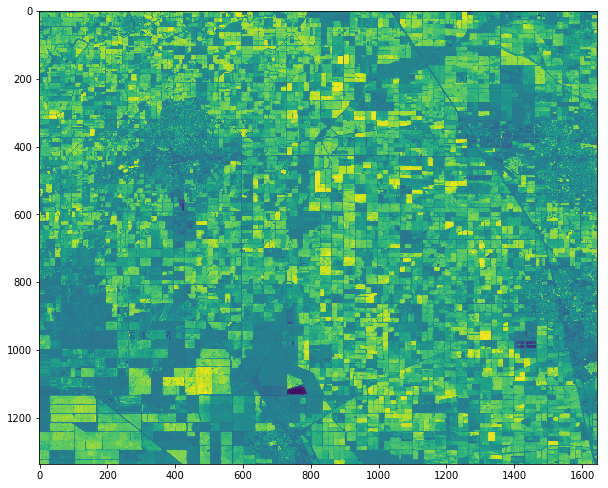

In [334]:
plt.figure(figsize=[10,10])
plt.imshow(data[0,:,:])

In [335]:
data.shape

(1, 1336, 1646)

Download images png

In [336]:
download_png(images, path_out='./png/sentinel_rgb.png', mn=0, mx=0.3, scale=scale, bandNames = ['B4','B3','B2'], region = region)

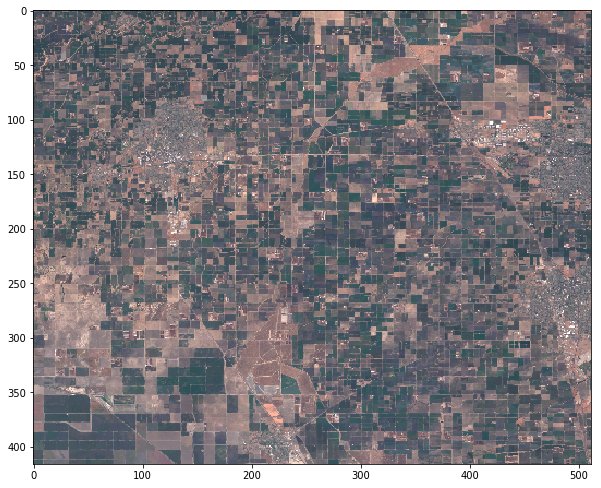

In [337]:
plt.figure(figsize=[10,10])
plt.imshow(plt.imread('./png/sentinel_rgb.png'))

In [340]:
plt.imread('./png/sentinel_rgb.png').shape

(416, 512, 3)

### USDA NASS Cropland Data Layers
**Resolution**
30 meters

**Bands**

|Name 	    |Min|Max |Description 	|
|-----------|---|----|--------------|
|cropland 	|1 	|254 |Main crop-specific land cover classification.|
|cultivated |1 	|2   |Classification layer for identifying cultivated and non-cultivated land cover. Available from 2013 to 2017.|
|confidence |0 	|100 |Per-pixel predicted confidence of the given classification, with 0 being the least confident and 100 the most confident. Available from 2008 to 2017 (Note: Confidence for Florida and Washington D.C. is unavailable for 2010).|

Load USDA NASS Cropland Data Layers.

In [1062]:
dataset = ee.ImageCollection('USDA/NASS/CDL')\
    .filterBounds(geom)\
    .filterDate(startDate,stopDate)

**Cropland Class Table**

In [1063]:
cropland_info = pd.DataFrame({'cropland_class_values':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_values'),
                              'cropland_class_palette':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_palette'),
                              'cropland_class_names':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_names')
                             })
cropland_info.head()

,cropland_class_values,cropland_class_palette,cropland_class_names
0,0.0,000000,Background
1,1.0,ffd300,Corn
2,2.0,ff2626,Cotton
3,3.0,00a8e5,Rice
4,4.0,ff9e0c,Sorghum


In [1064]:
print("Number of images:", dataset.toList(dataset.size()).size().getInfo())

# First image
img = ee.Image(dataset.first())

# Choose the scale
img =  img.reproject(crs='EPSG:4326', scale=scale)

Number of images: 1


Display cropland

In [1065]:
# display images
display_image(img, region, 1, 254, bandNames='cropland', title='Cropland')


 Cropland


In [1066]:
# display images
display_image(img, region, 1, 2, bandNames='cultivated', title='Cultivated')


 Cultivated


In [344]:
# display images
display_image(img, region, 0, 100, bandNames='confidence', title='Confidence')


 Confidence


Download images tif

In [345]:
download_image(img, 'cdl_data.zip', mn=1, mx=254, scale=scale, bandNames='cropland', region = region)

url:  https://earthengine.googleapis.com/api/download?docid=d89fdfdd7fdab8e3e4041bb6089eb3f4&token=3b87ba907df9367d19c9fd6916ad74c4
Download complete!


In [347]:
# Load tiff file data
with rasterio.open('./cdl_data/d89fdfdd7fdab8e3e4041bb6089eb3f4.cropland.tif') as src:
    data = src.read()
    profile = src.profile
    transform = src.transform

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


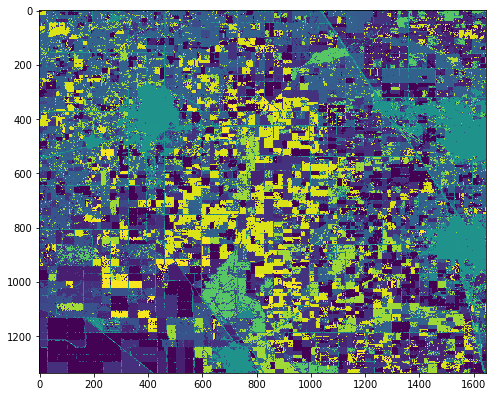

In [348]:
plt.figure(figsize=[8,8])
plt.imshow(data[0,:,:])

In [349]:
data.shape

(1, 1336, 1646)

Download images png

In [351]:
download_png(img, './png/CDL_cropland.png', 1, 254, scale, bandNames = 'cropland', region = region)

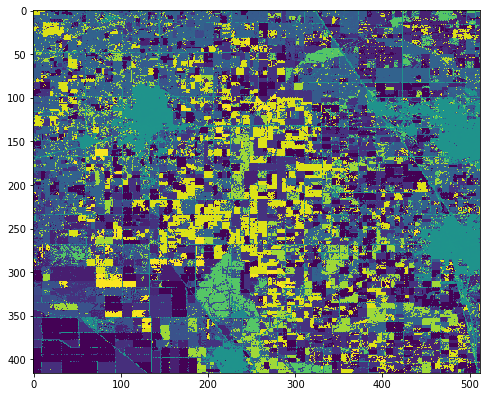

In [352]:
plt.figure(figsize=[8,8])
plt.imshow(plt.imread('./png/CDL_cropland.png'))

In [353]:
plt.imread('./png/CDL_cropland.png').shape

(416, 512)

## Preprocess the Data

In [477]:
def load_tif_bands(path, files):
    data = np.array([]) 
    for n, file in enumerate(files):
        image_path = path+file
        image = rasterio.open(image_path)
        data = np.append(data, image.read(1))
    data = data.reshape((n+1, image.read(1).shape[0], image.read(1).shape[1]))
    data = np.moveaxis(data, 0, 2)
    
    return data

In [1216]:
def display_channels(data, nChannels, titles = False):
    if nChannels == 1:
        plt.figure(figsize=(5,5))
        plt.imshow(data[:,:,0])
        if titles:
            plt.title(titles[0])
    else:
        fig, axs = plt.subplots(nrows=1, ncols=nChannels, figsize=(5*nChannels,5))
        for i in range(nChannels):
            ax = axs[i]
            ax.imshow(data[:,:,i])
            if titles:
                ax.set_title(titles[i])

In [525]:
# Load data
directory_x = "./data/"
directory_y = "./cdl_data/"
files_x = sorted(f for f in os.listdir(directory_x) if f.endswith('.' + 'tif'))
files_y = sorted(f for f in os.listdir(directory_y) if f.endswith('.' + 'tif'))

In [685]:
data_x = load_tif_bands(directory_x, files_x)
data_y = load_tif_bands(directory_y, files_y)

In [527]:
data_x.shape

(1336, 1646, 5)

data_y.shape

**Display input channels**

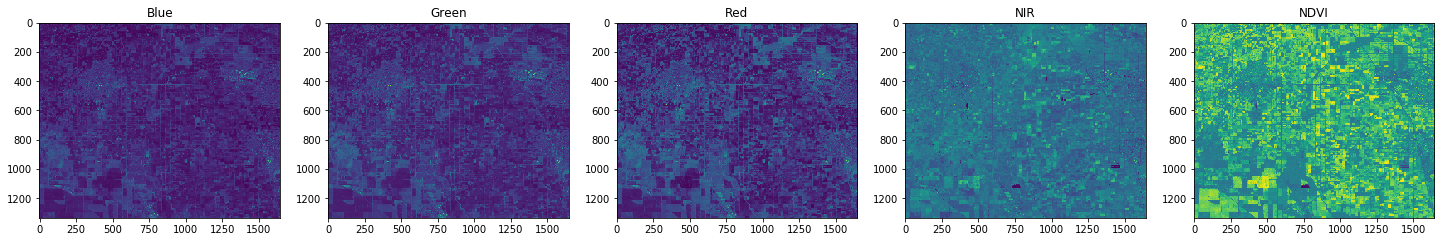

In [1218]:
display_channels(data_x, data_x.shape[2], titles=['Blue', 'Green', 'Red', 'NIR', 'NDVI'])

**Display output segmmentation**

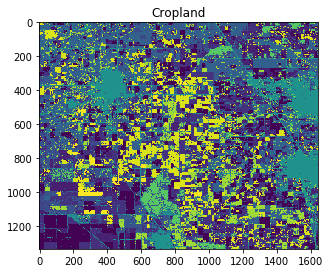

In [879]:
display_channels(data_y, data_y.shape[2], titles=['Cropland'])

**Preprocess class labels**

The classes range from 1 to 254

In [883]:
data_y[:,:,0]

array([[225., 225., 225., ..., 176., 176., 176.],
       [225., 225., 225., ..., 176., 176., 176.],
       [225., 225., 225., ..., 176., 176., 176.],
       ...,
       [  2.,   2.,   2., ...,  61.,  75.,  75.],
       [  2.,   2.,   2., ...,  75.,  75.,  75.],
       [  2.,   2.,   2., ..., 176., 176., 176.]])

The number of unique classes in this are is equal to:

In [884]:
len(np.unique(data_y[:,:,0]))

64

and the number of pixels by class

In [885]:
value, count = np.unique(data_y[:,:,0], return_counts=True)
df = pd.DataFrame({'cropland_class_values': value, 'cropland_class_counts': count})
df.sort_values(by='cropland_class_counts', ascending=False, inplace=True)
df = pd.merge(df, cropland_info, how='left', on=['cropland_class_values'])
df.head(10)

,cropland_class_values,cropland_class_counts,cropland_class_palette,cropland_class_names
0,36.0,253394,ffa5e2,Alfalfa
1,75.0,223121,00a582,Almonds
2,61.0,203688,bfbf77,Fallow/Idle Cropland
3,225.0,194621,ffd300,Dbl Crop WinWht/Corn
4,24.0,172580,a57000,Winter Wheat
5,2.0,170879,ff2626,Cotton
6,204.0,145810,00ff8c,Pistachios
7,76.0,140277,ead6af,Walnuts
8,1.0,118053,ffd300,Corn
9,69.0,98096,704489,Grapes


We take only the 10 most common classes and we aggregate the remaining ones into a single "other" class.

In [886]:
def replace_values(array, class_labels):
    new_labels = np.arange(len(class_labels), dtype=float)+1.
    array_new = np.copy(array)*0.
    for i in range(len(class_labels)):
        array_new[np.where(array == class_labels[i])] = new_labels[i]
        
    return array_new

In [887]:
# We replace the class labels
number_of_classes = 10
class_labels = np.array(df['cropland_class_values'].iloc[:number_of_classes])

new_data_y = np.copy(data_y[:,:,0])
new_data_y = replace_values(new_data_y, class_labels)

In [888]:
value, count = np.unique(new_data_y, return_counts=True)
df_new = pd.DataFrame({'cropland_class_values': value, 'cropland_class_counts': count})
df_new.sort_values(by='cropland_class_counts', ascending=False, inplace=True)
df_new = pd.merge(df_new, df.drop(columns='cropland_class_values'), how='left', on=['cropland_class_counts'])
df_new.fillna({'cropland_class_palette': '000000', 'cropland_class_names': 'Others'}, inplace=True)
df_new

,cropland_class_values,cropland_class_counts,cropland_class_palette,cropland_class_names
0,0.0,478537,000000,Others
1,1.0,253394,ffa5e2,Alfalfa
2,2.0,223121,00a582,Almonds
3,3.0,203688,bfbf77,Fallow/Idle Cropland
4,4.0,194621,ffd300,Dbl Crop WinWht/Corn
5,5.0,172580,a57000,Winter Wheat
6,6.0,170879,ff2626,Cotton
7,7.0,145810,00ff8c,Pistachios
8,8.0,140277,ead6af,Walnuts
9,9.0,118053,ffd300,Corn


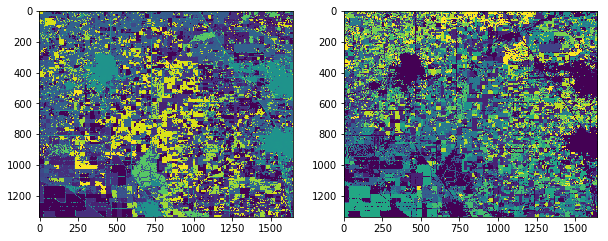

In [889]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax = axs[0]
ax.imshow(data_y[:,:,0])

ax = axs[1]
ax.imshow(new_data_y)

In [890]:
# Convert 1-dimensional class arrays to 11-dimensional class matrices
from keras.utils import np_utils
new_data_y = np_utils.to_categorical(new_data_y, len(class_labels)+1)

In [1068]:
data_y = new_data_y
data_y.shape

(1336, 1646, 11)

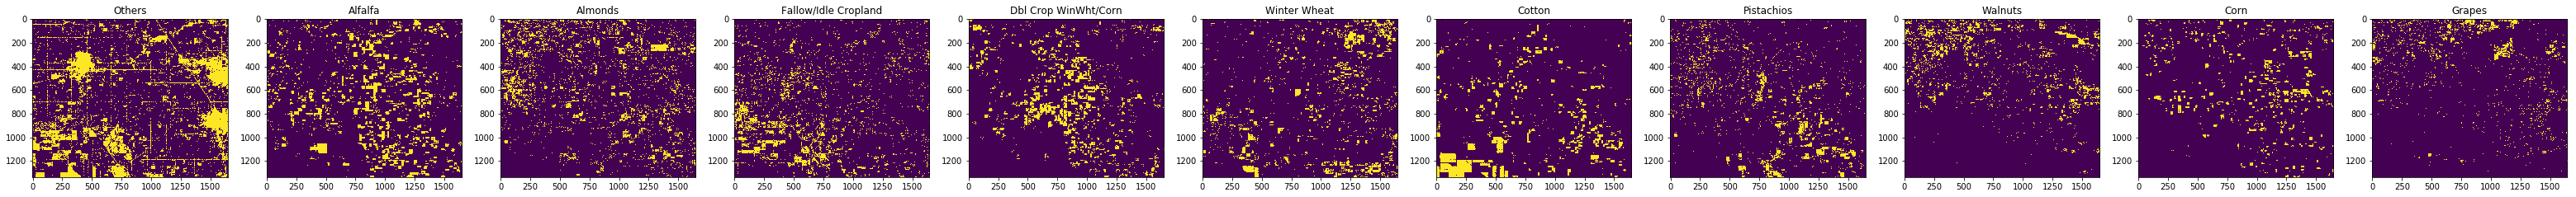

In [1219]:
display_channels(new_data_y, new_data_y.shape[2], titles=list(df_new['cropland_class_names']))

**Resize the images**

In [1158]:
def resize_data(data, patch_size = 100):
    y, x, Channels = data.shape
    
    num_pathces_per_frame = int(y/patch_size*x/patch_size)
    new_data = np.zeros((num_pathces_per_frame,patch_size,patch_size,Channels), dtype=np.float32)

    n=0
    for i in np.arange(int(x/patch_size)):
        for j in np.arange(int(y/patch_size)):
            xr=[int(patch_size*i),int(patch_size+patch_size*i)]
            yr=[int(patch_size*j),int(patch_size+patch_size*j)]

            new_data[n,:,:,:] = data[yr[0]:yr[1],xr[0]:xr[1],:]

            n=n+1
    return new_data

In [1169]:
x = resize_data(data_x, patch_size = 50)
y = resize_data(data_y, patch_size = 50)

In [1170]:
x.shape

(879, 50, 50, 5)

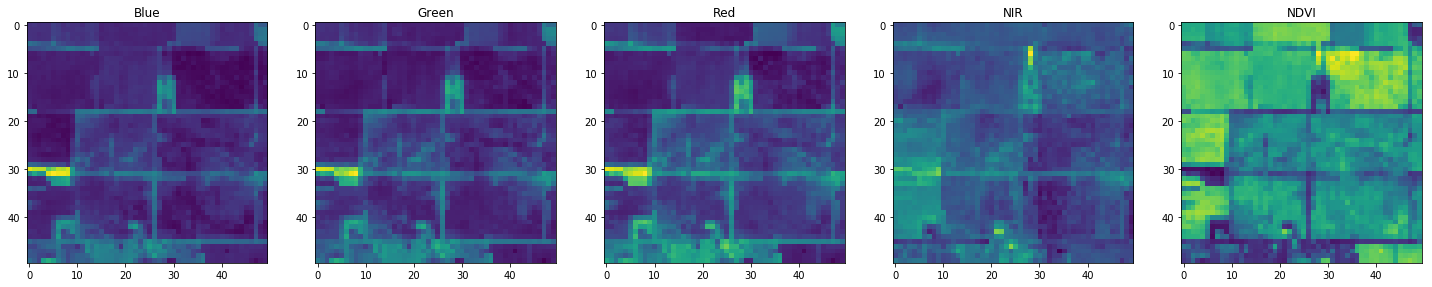

In [1171]:
display_channels(x[0,:,:,:], x.shape[3], titles=['Blue', 'Green', 'Red', 'NIR', 'NDVI'])

In [1172]:
y.shape

(879, 50, 50, 11)

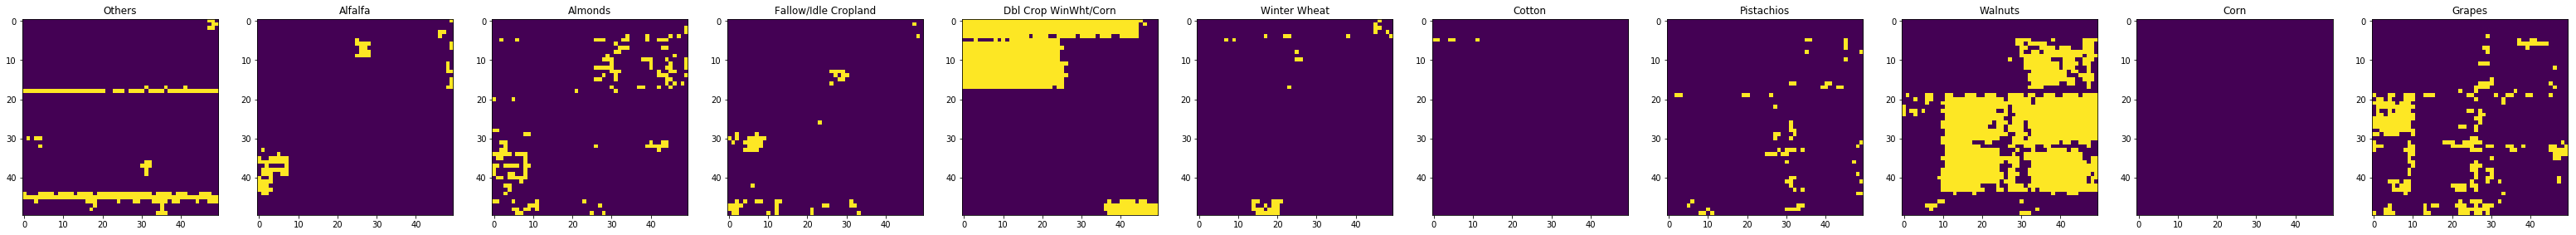

In [1173]:
display_channels(y[0,:,:], y.shape[3], titles=list(df_new['cropland_class_names']))

**Randomize the datasets**

In [1186]:
def randomize_datasets(data_x, data_y):
    t=data_x.shape[0]
    arr_t = np.arange(t)
    np.random.shuffle(arr_t)
    data_x = data_x[arr_t,:,:,:]
    data_y = data_y[arr_t,:,:,:]
    
    return data_x, data_y

In [1188]:
x_randm, y_randm = randomize_datasets(x, y)

**Training and validation sets**

In [1210]:
def train_validation_split(x, y, val_size=20):
    t=x.shape[0]
    size = int(t*((100-val_size)/100))
    
    xt = x[:size,:]
    xv = x[size:,:]
    yt = y[:size,:]
    yv = y[size:,:]
    
    return xt, xv, yt, yv

In [1211]:
x_train, x_validation, y_train, y_validation = train_validation_split(x_randm, y_randm)